In [150]:
import pandas as pd
import numpy as np
from math import pi
from scipy.interpolate import PchipInterpolator

from bokeh.plotting import figure, show
from bokeh.io import curdoc, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, PanTool, WheelZoomTool, HoverTool, AnnularWedge, ColumnDataSource, Legend, LegendItem, Plot, Range1d
from bokeh.palettes import PuBu, Inferno256, Category20
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
df_main = pd.read_csv("./referenced_data.csv")
df_main.dropna()

,Unnamed: 0,UBN,Reference No (URN),Date_Purchase,Date_Cash,Buyer,Party,Status,Denominations
0,0,TL11448,00001201904120000001166,12/Apr/2019,25/Apr/2019,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
1,1,TL11447,00001201904120000001166,12/Apr/2019,25/Apr/2019,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
2,2,TL11441,00001201904120000001166,12/Apr/2019,25/Apr/2019,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
3,3,OL1113,00001201904120000001166,12/Apr/2019,25/Apr/2019,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.01
4,4,OL1118,00001201904120000001166,12/Apr/2019,25/Apr/2019,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.01
...,...,...,...,...,...,...,...,...,...
18736,18736,OC15695,00001202401110000003729,11/Jan/2024,23/Jan/2024,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18737,18737,OC15693,00001202401110000003729,11/Jan/2024,23/Jan/2024,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18738,18738,OC15697,00001202401110000003729,11/Jan/2024,23/Jan/2024,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18739,18739,OC17803,00001202401110000003729,11/Jan/2024,23/Jan/2024,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00


In [152]:
def create_aggregate(df, grouper):
    df = df.groupby(grouper).agg({"Denominations": lambda x: x.sum()}).reset_index()
    df.sort_values(by="Denominations", ascending=False, inplace=True)
    return df

In [153]:
def plot_scatter(x, y, title='Scatter Plot of X and Y Coordinates', x_label='X', y_label='Y', color="cyan", color_map=None, size_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    use_color = color_map if color_map is not None else color
    use_size = size_map if size_map is not None else 8
    p.scatter(x, y, size=use_size, color=use_color, alpha=0.5, legend_label='Data')

    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    trendline = slope * x + intercept
    p.line(x, trendline, line_color='blue', line_width=1, legend_label='Trendline')

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [154]:
def plot_lines(df, x, y, cat, title='Line Chart', x_label='X', y_label='Y', color_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=1200, height=600, title=title)

    aggregated_df = df.groupby(cat)[y].sum().reset_index()
    top_20_categories = aggregated_df.nlargest(20, y)[cat]
    df = df[df[cat].isin(top_20_categories)]

    categories = df[cat].unique()
    colors = color_map if color_map else Category20[len(categories)]

    for i, category in enumerate(categories):
        category_data = df[df[cat] == category]
        p.line(category_data[x], category_data[y], line_color=colors[i % len(colors)], line_width=2, legend_label=category)

    p.legend.spacing = 0
    p.legend.margin = 0
    p.legend.padding = 0
    p.legend.label_text_font_size = '6pt'
    p.legend.click_policy = 'hide'
    p.add_layout(p.legend[0], 'right')

    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [155]:
def plot_donut_chart(column, title='Donut Chart', color_map=None):
    output_notebook()

    xdr = Range1d(start=-2, end=2)
    ydr = Range1d(start=-2, end=2)

    p = Plot(x_range=xdr, y_range=ydr)
    p.title.text = title
    p.toolbar_location = None

    aggregated = column.value_counts()
    percentages = aggregated.apply(lambda x: x/aggregated.sum())
    angles = percentages.map(lambda x: 2*pi*x).cumsum().tolist()

    source = ColumnDataSource(dict(
        start  = [0] + angles[:-1],
        end    = angles,
        colors = color_map
    ))

    glyph = AnnularWedge(x=0, y=0, inner_radius=1.2, outer_radius=1.8,
                         start_angle="start", end_angle="end",
                         line_color="grey", line_width=3, fill_color="colors")
    r = p.add_glyph(source, glyph)

    legend = Legend(location="center")
    for i, name in enumerate([key for key, value in aggregated.items()]):
        legend.items.append(LegendItem(label=name, renderers=[r], index=i))
    p.add_layout(legend, "center")

    show(p)

In [156]:
parties_agg = create_aggregate(df_main, ["Party"])
parties_agg

,Party,Denominations
5,BHARATIYA JANATA PARTY,6060.5111
3,ALL INDIA TRINAMOOL CONGRESS,1609.5314
16,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",1421.8655
4,BHARAT RASHTRA SAMITHI,1214.7099
7,BIJU JANATA DAL,775.5000
8,DRAVIDA MUNNETRA KAZHAGAM (DMK),639.0000
23,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU C...,337.0000
22,TELUGU DESAM PARTY,218.8800
19,SHIVSENA,159.3814
17,RASHTRIYA JANTA DAL,73.5000


In [157]:
buyers_agg = create_aggregate(df_main, ["Buyer"])
buyers_agg

,Buyer,Denominations
356,FUTURE GAMING AND HOTEL SERVICES PR,1208.0000
654,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,821.0000
868,QWIKSUPPLYCHAINPRIVATELIMITED,410.0000
419,HALDIA ENERGY LIMITED,377.0000
1252,VEDANTA LIMITED,375.6500
...,...,...
73,ANKUR SINGHAL S O SH ANIL SIN,0.0001
272,DAMINI NATH,0.0001
696,MR. SAMEER BHATIA,0.0001
88,ARAVIND S,0.0001


In [158]:
party_buyers_agg = create_aggregate(df_main, ["Party", "Buyer"])
party_buyers_agg

,Party,Buyer,Denominations
789,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,519.0000
1093,DRAVIDA MUNNETRA KAZHAGAM (DMK),FUTURE GAMING AND HOTEL SERVICES PR,453.0000
110,ALL INDIA TRINAMOOL CONGRESS,FUTURE GAMING AND HOTEL SERVICES PR,435.0000
872,BHARATIYA JANATA PARTY,QWIKSUPPLYCHAINPRIVATELIMITED,375.0000
121,ALL INDIA TRINAMOOL CONGRESS,HALDIA ENERGY LIMITED,281.0000
...,...,...,...
1523,SHIROMANI AKALI DAL,SANDEEP KHANNA AND ASSOCIATES,0.0040
1525,SHIROMANI AKALI DAL,VIKAS KUMAR GARG,0.0030
1521,SHIROMANI AKALI DAL,GOURAV KUMAR,0.0030
1028,BHARATIYA JANATA PARTY,WARORA CHANDRAPUR BALLARPUR TOLLRO,0.0010


In [159]:
party_buyers_agg = create_aggregate(df_main, ["Party", "Buyer", "Date_Purchase"])
party_buyers_agg

,Party,Buyer,Date_Purchase,Denominations
1178,BHARATIYA JANATA PARTY,QWIKSUPPLYCHAINPRIVATELIMITED,05/Jan/2022,200.0000
1179,BHARATIYA JANATA PARTY,QWIKSUPPLYCHAINPRIVATELIMITED,11/Nov/2022,125.0000
1067,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,11/Apr/2023,115.0000
1484,DRAVIDA MUNNETRA KAZHAGAM (DMK),FUTURE GAMING AND HOTEL SERVICES PR,07/Apr/2022,100.0000
1046,BHARATIYA JANATA PARTY,MADANLAL LTD.,08/May/2019,100.0000
...,...,...,...,...
2023,SHIROMANI AKALI DAL,VIKAS KUMAR GARG,18/Apr/2019,0.0030
2018,SHIROMANI AKALI DAL,GOURAV KUMAR,20/Apr/2019,0.0030
1376,BHARATIYA JANATA PARTY,WARORA CHANDRAPUR BALLARPUR TOLLRO,15/Nov/2023,0.0010
1187,BHARATIYA JANATA PARTY,RAIPUR BOTLING COMPANY,16/Apr/2019,0.0001


In [160]:
party_buyers_agg.iloc[:20]["Party"].value_counts()

Party
BHARATIYA JANATA PARTY                                          11
ALL INDIA TRINAMOOL CONGRESS                                     5
DRAVIDA MUNNETRA KAZHAGAM (DMK)                                  2
YSR  CONGRESS PARTY  (YUVAJANA SRAMIKA RYTHU CONGRESS PARTY)     2
Name: count, dtype: int64

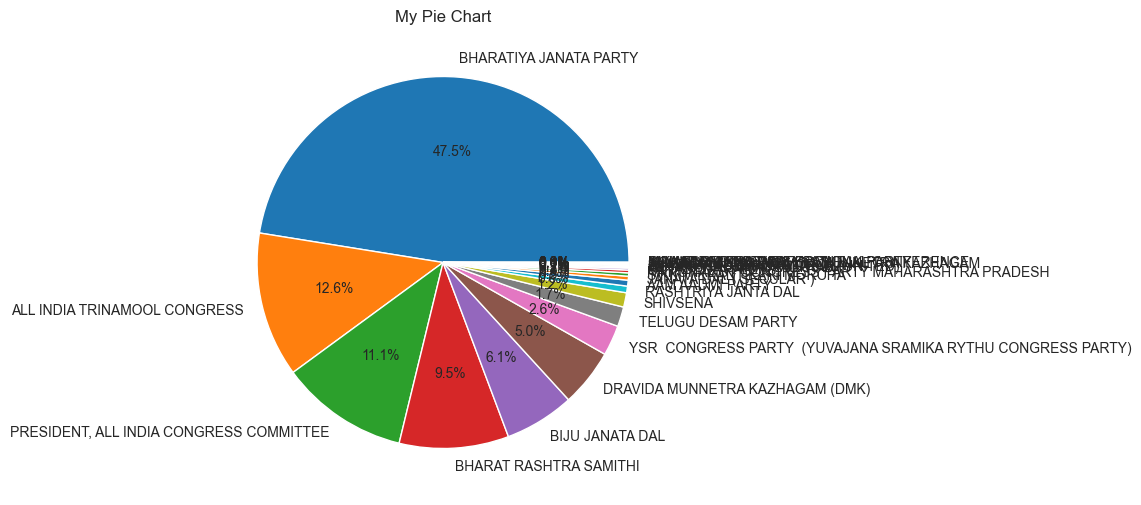

In [163]:
# plot_donut_chart(party_buyers_agg["Party"], color_map=Inferno256[len(party_buyers_agg["Party"].unique())])
sns.set_style("darkgrid")
plt.figure(figsize=(6,8))
plt.pie(parties_agg['Denominations'], labels=parties_agg['Party'], autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()

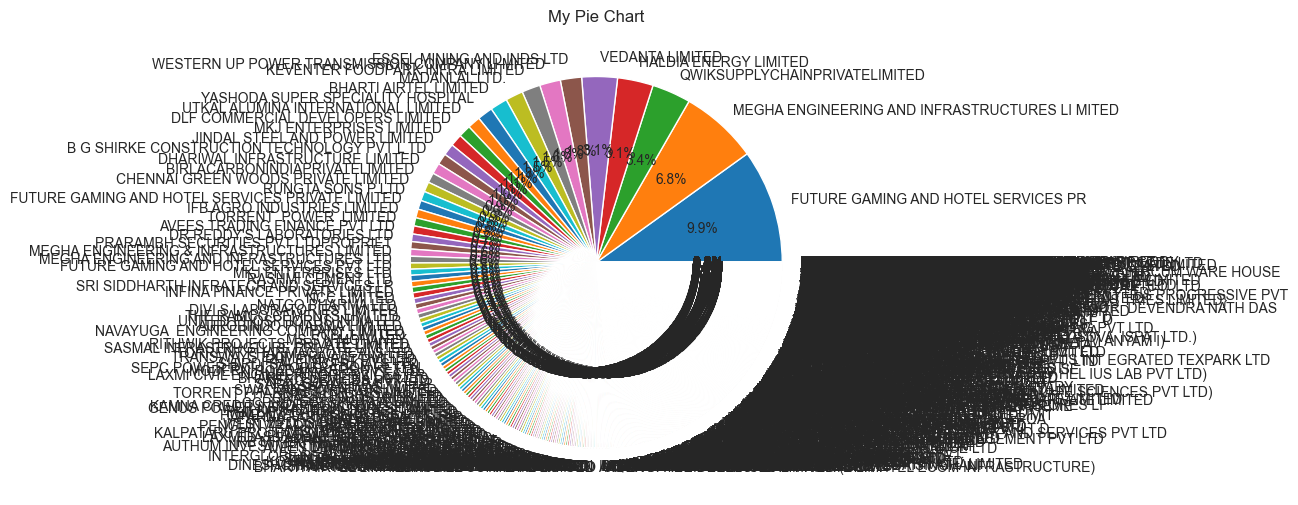

In [166]:
plt.figure(figsize=(6,8))
plt.pie(buyers_agg['Denominations'], labels=buyers_agg['Buyer'], autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()